# 🎨 Multimodalna klasifikacija umetničkih stilova

In [1]:
%pip install pandas numpy opencv-python tensorflow scikit-learn datasets matplotlib seaborn tabulate

Note: you may need to restart the kernel to use updated packages.


Cilj ovog projekta je klasifikacija umetničkih slika prema stilu pomoću **konvolucionih neuronskih mreža (CNN)** i **multimodalnog pristupa** koji kombinuje slike i metapodatke (umetnik, godina, žanr).


In [2]:

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nevenica\.julia\conda\3\x86_64\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parametri eksperimenta

Definišu se osnovni parametri kao što su veličina slike, broj epoha i broj uzoraka koji se koristi iz WikiArt skupa podataka.

In [3]:
MAX_SAMPLES = 20000
TOP_N_STYLES = 50 
TOP_N_ARTISTS = 40
TOP_N_GENRES = 40 
IMG_SIZE = 160
BATCH_SIZE = 32
NUM_EPOCHS = 30
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

## Učitavanje i podela podataka

Koristi se **WikiArt** dataset. Slike se preprocesiraju na $160 \times 160$, dok se metapodaci (godina, top $40$ umetnika/žanrova) transformišu u numeričke vektore za fuziju. Zadržano je $50$ najčešćih stilova za klasifikaciju. Podaci su podeljeni na trening, validacioni i test skup.

In [4]:
from artstyles import load_data 

(X_train_img, X_val_img, X_test_img,
 y_train_cat, y_val_cat, y_test_cat,
 y_test_enc, le, train_meta, val_meta, test_meta, NUM_CLASSES) = load_data()

print(f"Trening primeri: {len(X_train_img)}")
print(f"Validacioni primeri {len(X_val_img)}")
print(f"Test primeri: {len(X_test_img)}")

Trening primeri: 13202
Validacioni primeri 2829
Test primeri: 2829


In [5]:
def plot_history(history, model_name):
    plt.figure(figsize=(15, 5))
    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening Loss')
    plt.plot(history.history['val_loss'], label='Validacioni Loss')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Epoha')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history[acc_key], label='Trening Accuracy')
    plt.plot(history.history[val_acc_key], label='Validacioni Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Epoha')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Treniranje modela

Treniraju se dva modela:
1. **Samo CNN (Vizuelni model):** Koristi samo slike
2. **Multimodalni model (Fuzija):** Kombinuje slike i metapodatke

Za kontrolu *overfittinga* koristi se Augmentacija slika i rani prekid (`EarlyStopping` sa `patience=7`).

## Arhitektura Korišćenog CNN Modela
1.  **Ekstrakcija Obeležja:** Slika ($160 \times 160$) prolazi kroz **četiri para** **Konvolucionih slojeva** (`Conv2D`) i **Slojeva za Smanjenje** (`MaxPooling2D`).
    * **Svrha:** Konvolucioni slojevi uče oblike (ivice, teksture), dok slojevi za smanjenje stalno smanjuju veličinu slike da bi se zadržale samo najvažnije, **apstraktne karakteristike** stila.
2.  **Priprema:** Dobijeni apstraktni 3D podaci se "izravnavaju" slojem `Flatten` u dugačak 1D vektor.
3.  **Klasifikacija:** Taj vektor ulazi u **Potpuno Povezani sloj** (`Dense 256`) i na kraju u **Izlazni sloj** (`Dense 50, Softmax`) koji daje finalnu verovatnoću pripadnosti svakom od 50 stilova.

In [6]:
from artstyles import train_models

cnn_model, history_cnn, multi_model, history_multi = train_models(
    X_train_img, y_train_cat, X_val_img, y_val_cat,
    train_meta, val_meta, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, early_stop
)

c:\Users\Nevenica\.julia\conda\3\x86_64\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 129s 305ms/step - accuracy: 0.1189 - loss: 3.3201 - val_accuracy: 0.1439 - val_loss: 3.2258
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 118s 285ms/step - accuracy: 0.1360 - loss: 3.1593 - val_accuracy: 0.1340 - val_loss: 3.1232
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 116s 282ms/step - accuracy: 0.1466 - loss: 3.1041 - val_accuracy: 0.1527 - val_loss: 3.0560
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 116s 280ms/step - accuracy: 0.1525 - loss: 3.0572 - val_accuracy: 0.1658 - val_loss: 3.0218
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 115s 279ms/step - accuracy: 0.1562 - loss: 3.0163 - val_accuracy: 0.1764 - val_loss: 3.0221
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 115s 279ms/step - accuracy: 0.1669 - loss: 2.9761 - val_accuracy: 0.1644 - val_loss: 2.9789
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 115s 278ms/step - accuracy: 0.1767 - loss: 2.9379 - val_accuracy: 0.1750 - val_loss: 2.9667
Epoch 8/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 115s 278ms/step - accuracy: 0.1840 -

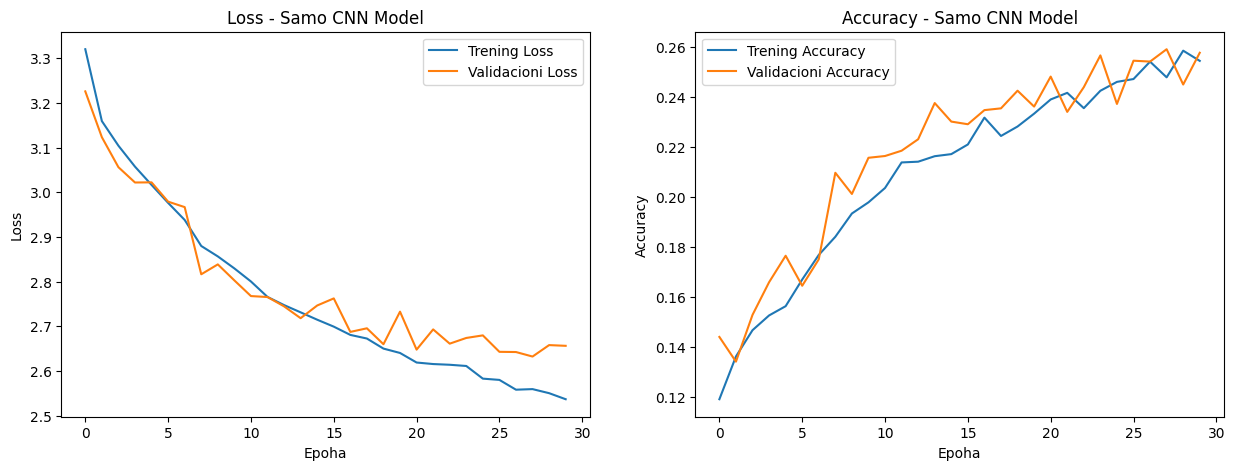

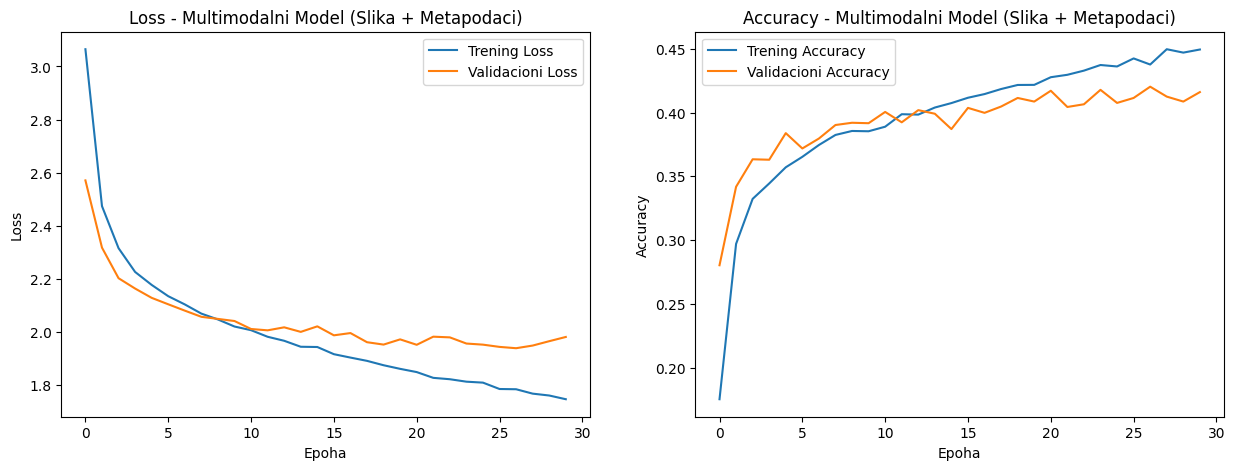

In [7]:
plot_history(history_cnn, "Samo CNN Model")
plot_history(history_multi, "Multimodalni Model (Slika + Metapodaci)")

### Tumačenje Grafova Treninga (Loss i Accuracy)

Grafovi prikazuju kako su se performanse modela menjale tokom epoha na trening i validacionom skupu.

#### **1. Loss (Gubitak) Graf**

* **Opšti trend (Konveksni pad):** U oba modela (CNN i Multimodalni), i **Trening Loss** i **Validacioni Loss** uspešno padaju tokom vremena (konveksan oblik). Ovo je dobar znak koji potvrđuje da model **efikasno uči** iz podataka i smanjuje grešku.
* **Blagi Overfitting:** U oba slučaja (posebno kod CNN modela), primećuje se da **Validacioni Loss na kraju ostane iznad Trening Loss-a** (ili počne ponovo blago da raste). Ovo je klasičan signal blagog **overfittinga**, gde model postiže odlične rezultate na podacima koje je video (trening), ali malo lošije na neviđenim podacima (validacija).

#### **2. Accuracy (Tačnost) Graf**

* **Opšti trend (Konkavni rast):** Tačnost za oba modela raste, prateći **konkavan oblik** (brzi rast na početku, sporiji rast pri kraju). 
* **Overfitting i Tačnost:** Kao i kod *Loss-a*, to što **Trening Accuracy na kraju ostaje iznad Validacionog Accuracy-ja** samo potvrđuje postojanje blagog *overfittinga*, što je i razlog za korišćenje `EarlyStopping` i `Dropout` tehnika.

**Zaključak grafova:** Obe mreže se **stabilno treniraju** i postižu konvergenciju, s tim da je multimodalni model značajno uspešniji (tj. počinje i završava na znatno višoj tačnosti).

## Evaluacija i prikaz rezultata

- Izračunava se tačnost i F1-score za oba modela.
- Prikazuje se confusion matrix za bolji model.

89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step


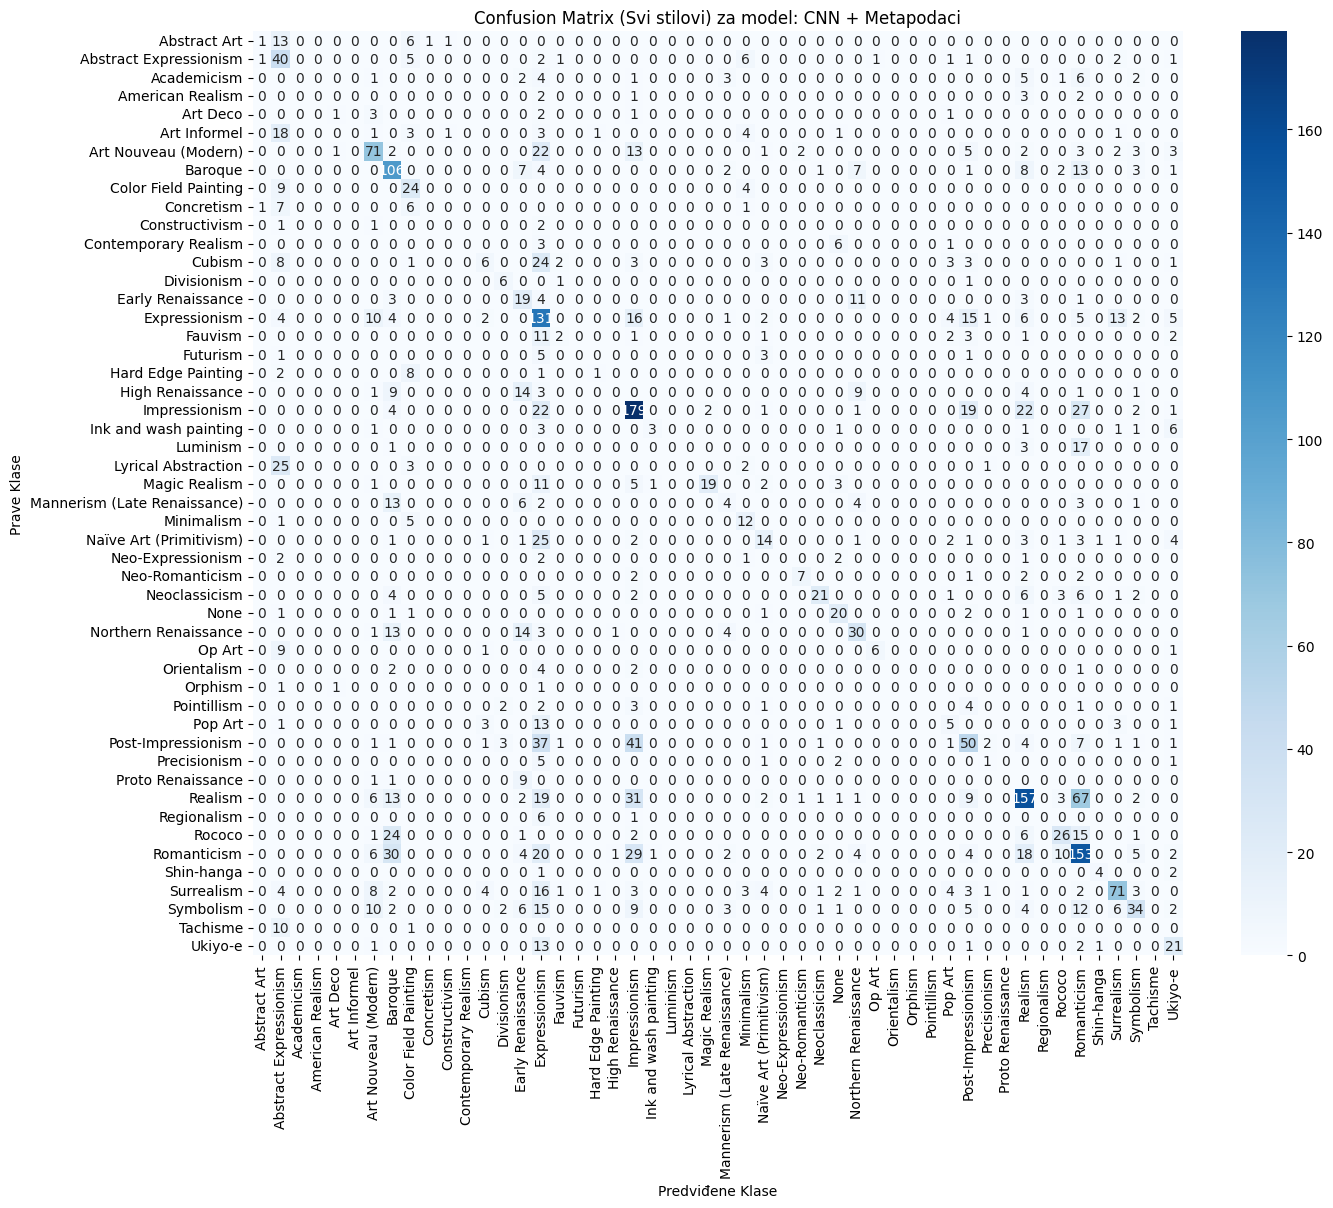

,Model,Accuracy,F1-score (Weighted)
0,Samo CNN,0.266525,0.225903
1,CNN + Metapodaci,0.440085,0.415950


In [8]:
from artstyles import evaluate_models

results = evaluate_models(
    cnn_model, multi_model,
    X_test_img, test_meta,
    y_test_enc, y_test_cat, le
)

results

### Tumačenje Confussion Matrix-a

* **Dijagonala (Uspeh):** Brojevi duž dijagonale pokazuju koliko je puta model **tačno pogodio** stil (npr., Impresionizam je pogođen kao Impresionizam).
* **Van Dijagonale (Greške):** Brojevi van dijagonale su **greške**. Visok broj van dijagonale znači da model **često meša** dva stila (npr., Prava: *Barok*, Predviđen: *Romantizam*).

# ✅ Zaključak

Glavni nalaz ovog eksperimenta je **izrazita prednost multimodalnog modela** u klasifikaciji umetničkog stila.

1. **Samo slike:** Model koji koristi **samo vizuelne podatke (CNN)** na rezoluciji **$160 \times 160$** postigao je tačnost od **$\approx 26.65\%$** i F1-score od $\approx 22.59\%$. Ova tačnost, iako bolja od slučajnog pogađanja, ukazuje da **sami vizuelni podaci nisu dovoljni** za pouzdano razlikovanje **50 vizuelno sličnih stilova**.

2. **Metapodaci i slike:** Model koji kombinuje slike i metapodatke (**CNN + Metapodaci**) postigao je tačnost od **$\approx 44.01\%$** i F1-score od $\approx 41.60\%$. To predstavlja značajno **poboljšanje performansi** od približno **$17.36$%**.

3. **Rezultat:** Ovaj rezultat snažno dokazuje da su informacije o **umetniku, datumu nastanka i žanru** od kritične važnosti i da su ključne za precizno određivanje stila, efektivno **kompenzujući** nedostatak finih vizuelnih detalja.